Rerun the whole notebook and put the txt files in the directory to produce the same results. Hyperparameters can be changed as desired.


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import time
np.random.seed(0)

In [0]:
###########Read data##############
##Store the coordinates of the cities in a dictionary where keys are the id's 
##of cities and values are [x,y] coordinates.
##A matrix where the entry A_(i,j) corresponds to the euclidian distance
##between city i and city j is also created.

##14-Staedte in Burma (Zaw Win)
#Read Coordinates
flag = 0
burma_coords = dict()
with open("burma14.tsp.txt") as fp: 
    for line in fp:
      if "NODE_COORD_SECTION" in line:
        flag = 1
      elif "EOF" in line:
        break
      elif flag == 1:
        line_list = line.strip('\n').split(" ")
        line_list = list(filter(lambda a: a != '',line_list))
        burma_coords.update( {int(line_list[0]): [float(line_list[1]), float(line_list[2])]} )
#Calculate euclidian distance
burma = np.zeros((14,14))
for i in range(1,15):
  for j in range(1,15):
    burma[i-1][j-1] = np.sqrt((burma_coords[i][0] - burma_coords[j][0])**2 + (burma_coords[i][1] - burma_coords[j][1])**2)

##29 Cities in Bavaria, geographical distances (Groetschel,Juenger,Reinelt)
#Read Coordinates
flag = 0
bays_coords = dict()
with open("bayg29_2.tsp.txt") as fp: 
    for line in fp:
      if "DISPLAY_DATA_SECTION" in line:
        flag = 1
      elif "EOF" in line:
        break
      elif flag == 1:
        line_list = line.strip('\n').split(" ")
        line_list = list(filter(lambda a: a != '',line_list))
        bays_coords.update( {int(line_list[0]): [float(line_list[1]), float(line_list[2])]} )
#Calculate euclidian distance
bays = np.zeros((29,29))
for i in range(1,30):
  for j in range(1,30):
    bays[i-1][j-1] = np.sqrt((bays_coords[i][0] - bays_coords[j][0])**2 + (bays_coords[i][1] - bays_coords[j][1])**2)

In [0]:
#Calculate the fitness of an individual given the distance matrix.
#Sum the distance between each adjacent city in the route.
#Fitness is negative of total distance as less distance is better.
def fitness(individual,distances):
  fitness = 0
  for i in range(1,len(individual)):
    fitness += distances[int(individual[i]-1)][int(individual[i-1]-1)] 
  return -1*fitness

In [0]:
#Generate an offspring from 2 parents using order crossover.
def crossover(parent_1,parent_2):
  dim = len(parent_1)
  offspring = np.zeros(dim)
  #Randomly choose cut points where start < end
  start= np.random.randint(low=0, high=dim-2, size=1)[0]
  end = np.random.randint(low=start+1, high=dim-1, size=1)[0]
  #Copy between cut points to offspring using parent_1
  cities_copied = []
  for i in range(start, end+1):
      offspring[i] = parent_1[i]
      cities_copied.append(parent_1[i])
  #Fill in missing cities using parent_2
  to_be_copied = []
  for item in parent_2:
    if item not in cities_copied:
      to_be_copied.append(item)
  j = 0
  for i in range(dim):
    if offspring[i] == 0:
      offspring[i] = to_be_copied[j]
      j += 1
  return offspring

In [0]:
#perform reverse sequence mutation
def mutation(offspring):
  #Pick swap points
  a, b = np.random.randint(low=0, high=len(offspring)-1, size=2)
  #Swap
  temp = offspring[a]
  offspring[a] = offspring[b]
  offspring[b] = temp
  return offspring

In [0]:
#Binary tournament selection => pick 2 individuals randomly, 
#put the fittest one to mating pool.
def binary_tournament(population,mating_pool_size,distances):
  mating_pool = []
  counter = 0
  #Fill mating pool
  while len(mating_pool) != mating_pool_size:
    #Pick two individuals randomly
    a, b = np.random.randint(low=0, high=len(population), size=2)
    fitness_a = fitness(population[a],distances)
    fitness_b = fitness(population[b],distances)
    counter += 2
    if fitness_a > fitness_b:
      mating_pool.append(population[a])
    else:
      mating_pool.append(population[b])
  return mating_pool, counter

In [0]:
#Get best solution from a population.
#Return the total distance as well.
def get_best(population,distances):
  population_size = len(population)
  best_solution = population[0]
  best_fitness = fitness(population[0],distances)
  for i in range(1,population_size):
    fitness_score = fitness(population[i],distances)
    if best_fitness < fitness_score:
      best_fitness = fitness_score
      best_solution = population[i]
  return best_solution, -1*best_fitness

In [0]:
#Plot the path of the best solution
def plot_path(best_solution,coords):
  #Plotting line segments code obtained from:
  #https://kite.com/python/answers/how-to-draw-a-line-between-two-points-in-matplotlib-in-python
  #Plot line segments
  for i in range(1,len(best_solution)):
    point1 = coords[int(best_solution[i-1])]
    point2 = coords[int(best_solution[i])]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    plt.plot(x_values, y_values,color="black")
  #Mark the cities
  for item in coords.values():
    plt.plot(item[0], item[1], 'bo') 
  plt.xlabel("X Coordinate")
  plt.ylabel("Y Coordinate")
  plt.title("Best Solution")


In [0]:
#Simple EA
def Simple_EA(num_cities,distances,max_iter,mutation_prob,population_size,mating_pool_size):
  #Initialization
  counter = 0
  population = []
  for i in range(population_size):
    population.append(np.random.permutation(list(range(1,num_cities+1))))
  num_iter = 0
  #Terminate when max number of iterations is reached
  while num_iter < max_iter: 
    new_population = []
    #Construct the mating pool using binary tournament
    mating_pool, counter1 = binary_tournament(population,mating_pool_size,distances)
    counter += counter1
    #Randomly select parents from mating pool and perform crossover
    for i in range(population_size):
      parent_1, parent_2 = np.random.randint(low=0, high=mating_pool_size-1,size=2)
      offspring = crossover(mating_pool[parent_1],mating_pool[parent_2])
      #Perform mutation with certain probability
      if np.random.random() <= mutation_prob:
        offspring = mutation(offspring)
      new_population.append(offspring)
    #Generational gap replacement strategy = discard the previous generation completely.
    population = new_population
    best_solution, best_distance = get_best(population,distances)
    #Uncomment line below to make the function verbose
    #print("Iteration: " + str(num_iter) +"\n" + "Best Solution: " + str(best_solution) + "\n" +  "Best Distance: " + str(best_distance))
    num_iter += 1
  return best_solution, best_distance, num_iter, counter


In [0]:
#Perform local search to optimize each individual in population
def local_search(population,distances,path_length):
  new_population = []
  counter = 0
  for item in population:
    #pick a random point
    checkpoint = np.random.randint(low=0, high=len(population)-path_length, size=1)[0]
    #get all the permutations of the subpath starting from the random point 
    subpath = item[checkpoint:checkpoint+path_length-1]
    perms = list(itertools.permutations(subpath))
    best_fit = -1
    best_score = -100000000
    for item2 in perms:
      score = fitness(item2,distances)
      counter += 1
      if best_score < score:
        best_fit = item2
        best_score = score
    #replace subpath by lowest distance subpath
    new_item = item
    new_item[checkpoint:checkpoint+path_length-1] = best_fit
    new_population.append(new_item) 
  return new_population, counter

In [0]:
#Memetic Algorithm
def Memetic_Algorithms(num_cities,distances,max_iter,mutation_prob,population_size,mating_pool_size,path_length):
  #Initialization
  population = []
  counter = 0
  for i in range(population_size):
    population.append(np.random.permutation(list(range(1,num_cities+1))))
  #do local search on population
  population, counter1 = local_search(population,distances,path_length)
  num_iter = 0
  counter += counter1
  #Terminate when max number of iterations is reached
  while num_iter < max_iter: 
    new_population = []
    #Construct the mating pool using binary tournament
    mating_pool, counter2 = binary_tournament(population,mating_pool_size,distances)
    counter += counter2
    #Randomly select parents from mating pool and perform crossover
    for i in range(population_size):
      parent_1, parent_2 = np.random.randint(low=0, high=mating_pool_size-1,size=2)
      offspring = crossover(mating_pool[parent_1],mating_pool[parent_2])
      #Perform mutation with certain probability
      if np.random.random() <= mutation_prob:
        offspring = mutation(offspring)
      new_population.append(offspring)
    #Generational gap replacement strategy = discard the previous generation completely.
    #do local search on population
    population, counter3 = local_search(new_population,distances,path_length)
    counter += counter3
    best_solution, best_distance = get_best(population,distances)
    #Uncomment line below to make the function verbose
    #print("Iteration: " + str(num_iter) +"\n" + "Best Solution: " + str(best_solution) + "\n" +  "Best Distance: " + str(best_distance))
    num_iter += 1
  return best_solution, best_distance, num_iter, counter


In [0]:
#Initialize hyperparameters
population_size = 1000
mutation_prob = 0.01
mating_pool_size = 20
max_iter = 500
distances = bays
num_cities = distances.shape[0]

In [0]:
#averaging of solutions done 
solutions_EA = []
solutions_MA = []

In [32]:
###Simple EA
for i in range(10):
  start = time.time()
  best_solution, best_distance, num_iter, num_evals = Simple_EA(num_cities,distances,max_iter,mutation_prob,population_size,mating_pool_size)
  end = time.time()
  solutions_EA.append([best_solution, best_distance, (start-end), num_evals])
  print("Best solution: " + str(best_solution))
  print("Minimum Distance: " + str(best_distance))
  print("Number of iterations: " + str(num_iter))

Best solution: [26. 29.  3. 10. 15. 27.  6.  1. 28. 12.  9.  5.  2. 24.  8. 23. 16. 25.
  7. 19.  4. 13. 21. 20. 18. 14. 17. 22. 11.]
Minimum Distance: 12241.310340906994
Number of iterations: 500
Best solution: [ 3. 29.  5. 28.  1. 20. 10. 21. 23.  7. 25. 19. 15.  4. 27.  8. 24. 16.
 14. 22. 17. 18.  2. 26.  9. 12.  6. 13. 11.]
Minimum Distance: 12795.45401224888
Number of iterations: 500
Best solution: [21. 24. 23. 27.  8. 28.  1. 29. 26.  3. 11.  7. 25. 19.  4. 10.  2. 20.
 17. 22. 14. 18. 15. 16. 13.  5.  9.  6. 12.]
Minimum Distance: 12498.467838401602
Number of iterations: 500
Best solution: [18. 17. 14. 16. 27.  9.  5. 20. 10.  2. 21. 24.  1. 12. 26.  3. 29.  6.
 28. 13.  4. 15. 11. 19.  8. 23.  7. 25. 22.]
Minimum Distance: 13504.822135725193
Number of iterations: 500
Best solution: [ 3. 29. 26.  9.  2. 24.  8. 28.  1. 21.  6. 12.  5. 20. 10. 22. 13. 27.
 23. 16.  7. 25.  4. 19. 15. 18. 17. 14. 11.]
Minimum Distance: 12089.754894737287
Number of iterations: 500
Best solution: [

In [33]:
###Memetic
for i in range(10):
  start = time.time()
  best_solution, best_distance, num_iter, num_evals = Memetic_Algorithms(num_cities,distances,max_iter,mutation_prob,population_size,mating_pool_size,8)
  end = time.time()
  solutions_MA.append([best_solution, best_distance, (start-end), num_evals])
  print("Best solution: " + str(best_solution))
  print("Minimum Distance: " + str(best_distance))
  print("Number of iterations: " + str(num_iter))

Best solution: [ 3. 29. 26.  5.  8. 27. 16. 13. 10. 20.  2. 21.  9. 12.  6. 28.  1. 24.
 23.  7. 25. 19.  4. 15. 11. 22. 14. 18. 17.]
Minimum Distance: 9196.040431171275
Number of iterations: 500
Best solution: [12.  6.  9. 26. 29.  5. 21. 10.  4. 15. 18. 14. 17. 22. 11. 25.  7. 23.
 27.  8. 28.  1. 24. 16. 19. 13. 20.  2.  3.]
Minimum Distance: 9454.767937433104
Number of iterations: 500
Best solution: [23. 27.  8. 28.  9.  5. 21.  1. 24. 16. 13. 20. 15. 18. 14. 17. 22. 11.
  7. 25. 19.  4. 10.  2. 29.  3. 26.  6. 12.]
Minimum Distance: 10039.27753333427
Number of iterations: 500
Best solution: [12.  6. 24. 16.  4. 15. 11. 22. 17. 14. 20.  2. 29.  3. 26.  9.  5. 21.
 28.  1. 13. 10. 18. 19. 25.  7. 23. 27.  8.]
Minimum Distance: 10618.799047847826
Number of iterations: 500
Best solution: [21.  2. 20. 13.  4. 11. 22. 17. 19. 25.  7. 23. 16. 27.  8.  5. 29.  3.
 26.  9. 12.  6. 28.  1. 24. 10. 15. 18. 14.]
Minimum Distance: 10849.715809214338
Number of iterations: 500
Best solution: [17

In [35]:
print(solutions_EA)
print(solutions_MA)

[[array([26., 29.,  3., 10., 15., 27.,  6.,  1., 28., 12.,  9.,  5.,  2.,
       24.,  8., 23., 16., 25.,  7., 19.,  4., 13., 21., 20., 18., 14.,
       17., 22., 11.]), 12241.310340906994, -67.11980366706848, 20000], [array([ 3., 29.,  5., 28.,  1., 20., 10., 21., 23.,  7., 25., 19., 15.,
        4., 27.,  8., 24., 16., 14., 22., 17., 18.,  2., 26.,  9., 12.,
        6., 13., 11.]), 12795.45401224888, -68.56893110275269, 20000], [array([21., 24., 23., 27.,  8., 28.,  1., 29., 26.,  3., 11.,  7., 25.,
       19.,  4., 10.,  2., 20., 17., 22., 14., 18., 15., 16., 13.,  5.,
        9.,  6., 12.]), 12498.467838401602, -67.89091467857361, 20000], [array([18., 17., 14., 16., 27.,  9.,  5., 20., 10.,  2., 21., 24.,  1.,
       12., 26.,  3., 29.,  6., 28., 13.,  4., 15., 11., 19.,  8., 23.,
        7., 25., 22.]), 13504.822135725193, -67.17629384994507, 20000], [array([ 3., 29., 26.,  9.,  2., 24.,  8., 28.,  1., 21.,  6., 12.,  5.,
       20., 10., 22., 13., 27., 23., 16.,  7., 25.,  4., 19

In [0]:
#Copy best solution here
best_solution_EA = [12.,  6.,  9., 26.,  3.,  2., 21.,  5.,  1., 28.,  8., 16., 25.,7., 23., 27., 24., 13., 15., 14., 22., 17., 18.,  4., 20., 29.,10., 19., 11.]
best_solution_MA = [ 3., 29., 26.,  5.,  8., 27., 16., 13., 10., 20.,  2., 21.,  9.,12.,  6., 28.,  1., 24., 23.,  7., 25., 19.,  4., 15., 11., 22.,14., 18., 17.]

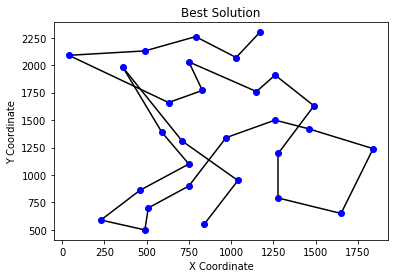

In [39]:
plot_path(best_solution_EA,bays_coords)


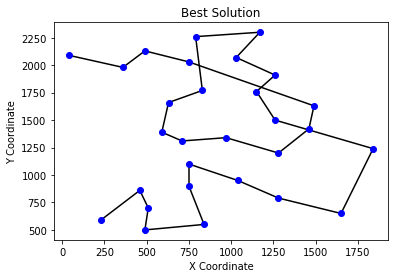

In [40]:
plot_path(best_solution_MA,bays_coords)

In [55]:
EA_mbf = solutions_EA[1][1] + solutions_EA[2][1] + solutions_EA[3][1]+ solutions_EA[4][1] + solutions_EA[5][1] + solutions_EA[6][1] + solutions_EA[7][1] + solutions_EA[8][1] + solutions_EA[9][1] + solutions_EA[0][1] 
EA_mbf = EA_mbf/10.0
print("EA MBF: " + str(EA_mbf))
EA_aet = solutions_EA[1][2] + solutions_EA[2][2] + solutions_EA[3][2]+ solutions_EA[4][2] + solutions_EA[5][2] + solutions_EA[6][2] + solutions_EA[7][2] + solutions_EA[8][2] + solutions_EA[9][2] + solutions_EA[0][2] 
EA_aet = EA_aet/-10.0
print("EA AET: " + str(EA_aet))
EA_aes = solutions_EA[1][3] + solutions_EA[2][3] + solutions_EA[3][3]+ solutions_EA[4][3] + solutions_EA[5][3] + solutions_EA[6][3] + solutions_EA[7][3] + solutions_EA[8][3] + solutions_EA[9][3] + solutions_EA[0][3] 
EA_aes = EA_aes/10.0
print("EA AET: " + str(EA_aes))

EA MBF: 12183.276531988542
EA AET: 67.144566822052
EA AET: 20000.0


In [56]:
MA_mbf = solutions_MA[1][1] + solutions_MA[2][1] + solutions_MA[3][1]+ solutions_MA[4][1] + solutions_MA[5][1] + solutions_MA[6][1] + solutions_MA[7][1] + solutions_MA[8][1] + solutions_MA[9][1] + solutions_MA[0][1] 
MA_mbf = MA_mbf/10.0
print("MA MBF: " + str(MA_mbf))
MA_aet = solutions_MA[1][2] + solutions_MA[2][2] + solutions_MA[3][2]+ solutions_MA[4][2] + solutions_MA[5][2] + solutions_MA[6][2] + solutions_MA[7][2] + solutions_MA[8][2] + solutions_MA[9][2] + solutions_MA[0][2] 
MA_aet = MA_aet/-10.0
print("EM AET: " + str(MA_aet))
MA_aes = solutions_MA[1][3] + solutions_MA[2][3] + solutions_MA[3][3]+ solutions_MA[4][3] + solutions_MA[5][3] + solutions_MA[6][3] + solutions_MA[7][3] + solutions_MA[8][3] + solutions_MA[9][3] + solutions_MA[0][3] 
MA_aes = MA_aes/10.0
print("MA AET: " + str(MA_aes))

MA MBF: 10358.438019394587
EM AET: 658.1892814159394
MA AET: 59491333.5
